In [ ]:
!pip install prettytable

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import random
from prettytable import PrettyTable

In [ ]:
def circle(xo,yo,r,noise_factor,num_points):
  x_data = []
  y_data = []
  angle = np.linspace( 0 , 2 * np.pi , num_points ) 
  x = xo + r * np.cos( angle ) 
  y = yo + r * np.sin( angle )
  for item in x:
     x_data.append(item + noise_factor*r*np.random.randn())
  for item in y:
    y_data.append(item + noise_factor*r*np.random.randn())
  return x_data,y_data

def random_sample(x_data,y_data):
  x_sample = []
  y_sample = []
  x_temp = random.sample(list(enumerate(x_data)),3)
  y_temp = random.sample(list(enumerate(y_data)),3)
  x_sample = [item[1] for item in x_temp]
  x_idx = [item[0] for item in x_temp]
  y_sample = [item[1] for item in y_temp]
  y_idx = [item[0] for item in y_temp]

  return x_sample,y_sample,x_idx,y_idx

def find_model(x,y):
  # supply x = [x1,x2,x3], y = [y1,y2,y2]
  A = np.array([[x[0],y[0],1],[x[1],y[1],1],[x[2],y[2],1]])
  B = np.array([[x[0]**2+y[0]**2],[x[1]**2+y[1]**2],[x[2]**2+y[2]**2]])
  par = -np.linalg.inv(A)@B
  xo = -par[0]/2
  yo = -par[1]/2
  radius = np.sqrt(xo**2+yo**2-par[2])
  return xo,yo,radius

def eval_model(xo,yo,radius,x_idx,y_idx,x_data,y_data,threshold):
  num_data_points = len(x_data)
  inliers = 0
  data_idxs = list(range(num_data_points))
  # print(data_idxs)
  # print(x_idx)
  data_idxs = [i for j, i in enumerate(data_idxs) if j not in x_idx]
  for idx in data_idxs:
    d = np.abs(np.sqrt((x[idx]-xo)**2 + (y[idx]-yo)**2) - radius)
    if d < threshold:
      inliers+=1
  return inliers


The estimated centre is (2.530334850045165, 4.544321810757396) and radius is 9.183627255390453.


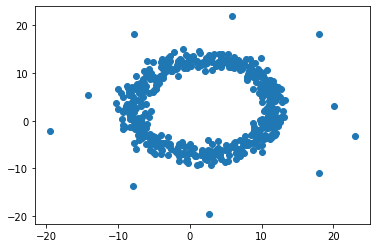

In [ ]:
num_points = 500
num_noise_samples = 10
threshold = 0.01
xio = 2
yio = 3
r = 10
noise_factor = 0.1
num_iterations = 100
result = []
x,y = circle(xio,yio,r,noise_factor,num_points)
x_noise,y_noise = circle(xio,yio,2*r,noise_factor,num_noise_samples)
x = x+x_noise
y = y+y_noise
plt.scatter(x,y)

for _ in range(num_iterations):
  x_sample,y_sample,x_idx,y_idx = random_sample(x,y)
  xo,yo,radius = find_model(x_sample,y_sample)
  inliers = eval_model(xo,yo,radius,x_idx,y_idx,x,y,threshold)
  result.append([inliers,xo,yo,radius])
  # print(inliers)
  # print(xo,yo,radius)

max_inliers = 0
index = None
for idx,i in enumerate(range(len(result))):
  if result[i][0] > max_inliers:
    index = idx
    max_inliers = result[i][0]
if index == None:
  print("No good sample found")
else:
  print(f"The estimated centre is {result[index][1][0],result[index][2][0]} and radius is {result[index][3][0]}.")

Q2 -Hough Transform

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

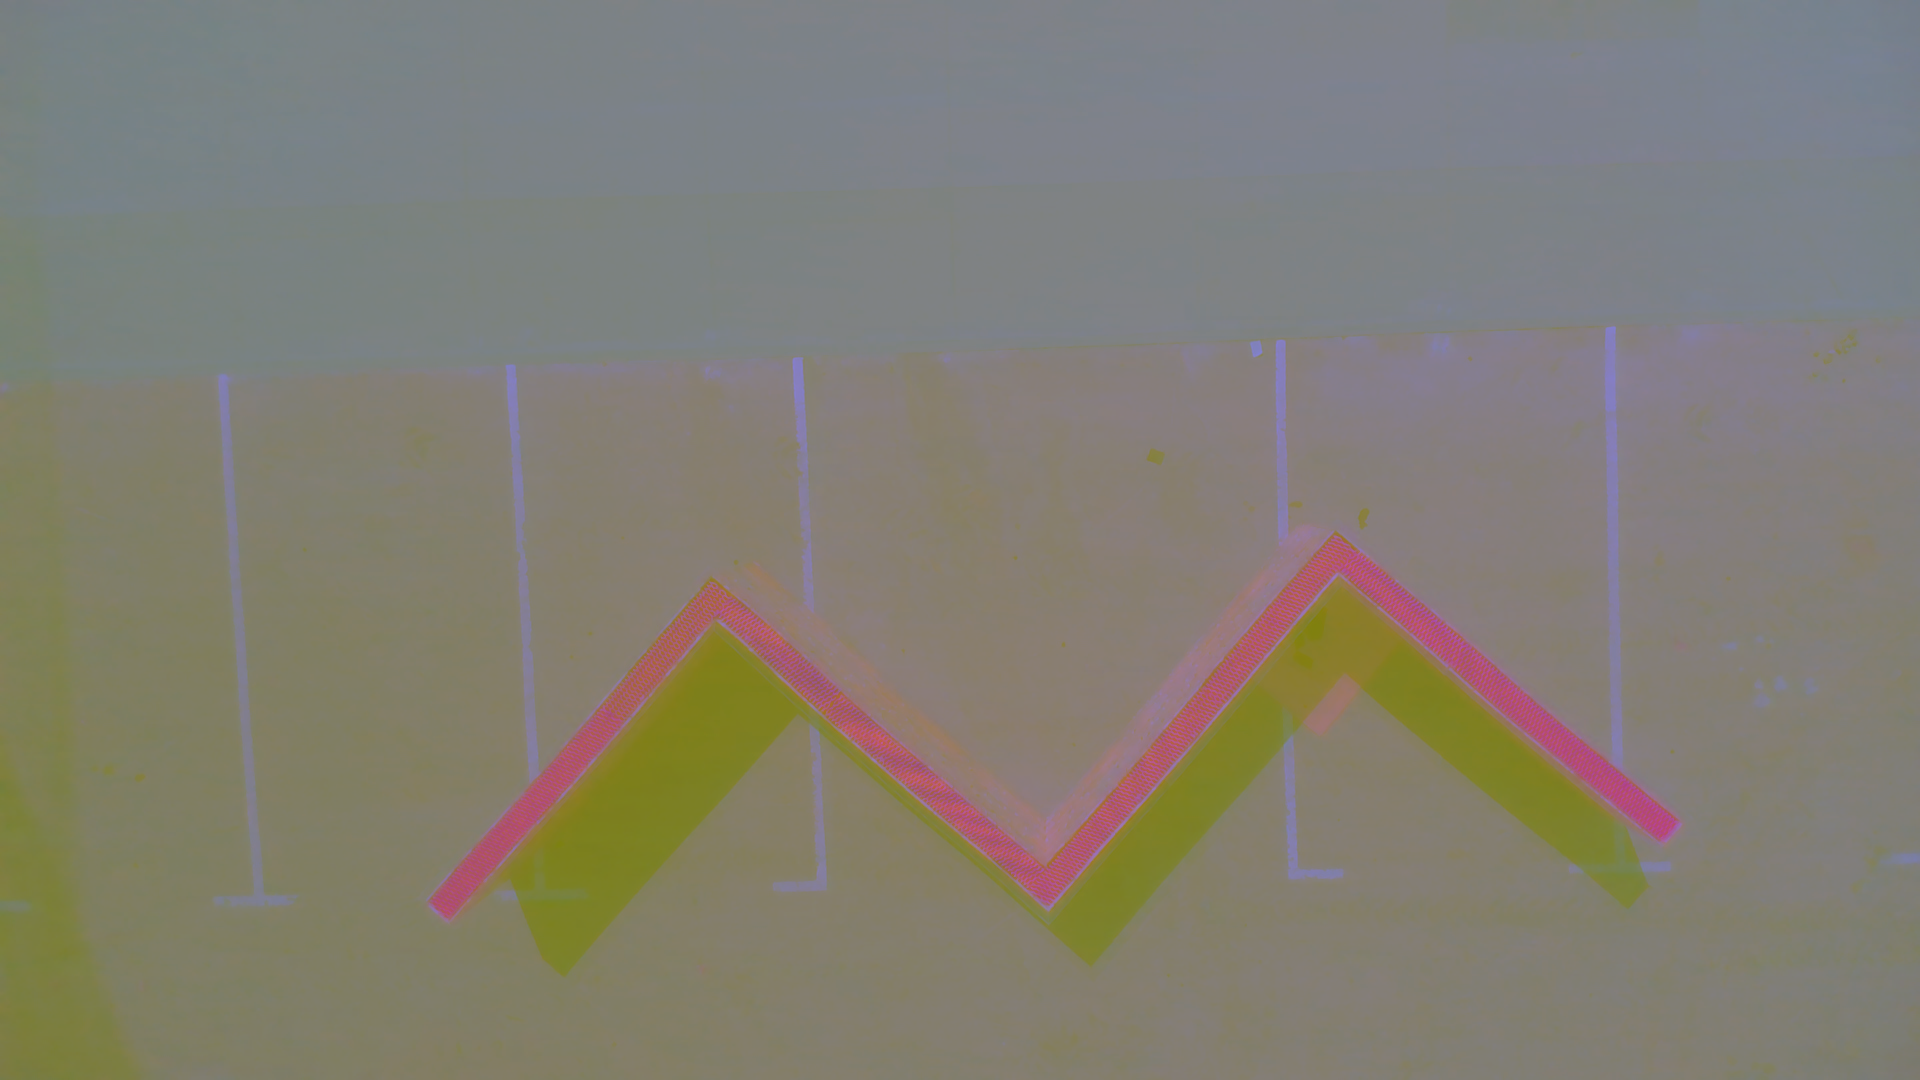

(1080, 1920, 3)
[ 58  99 170]


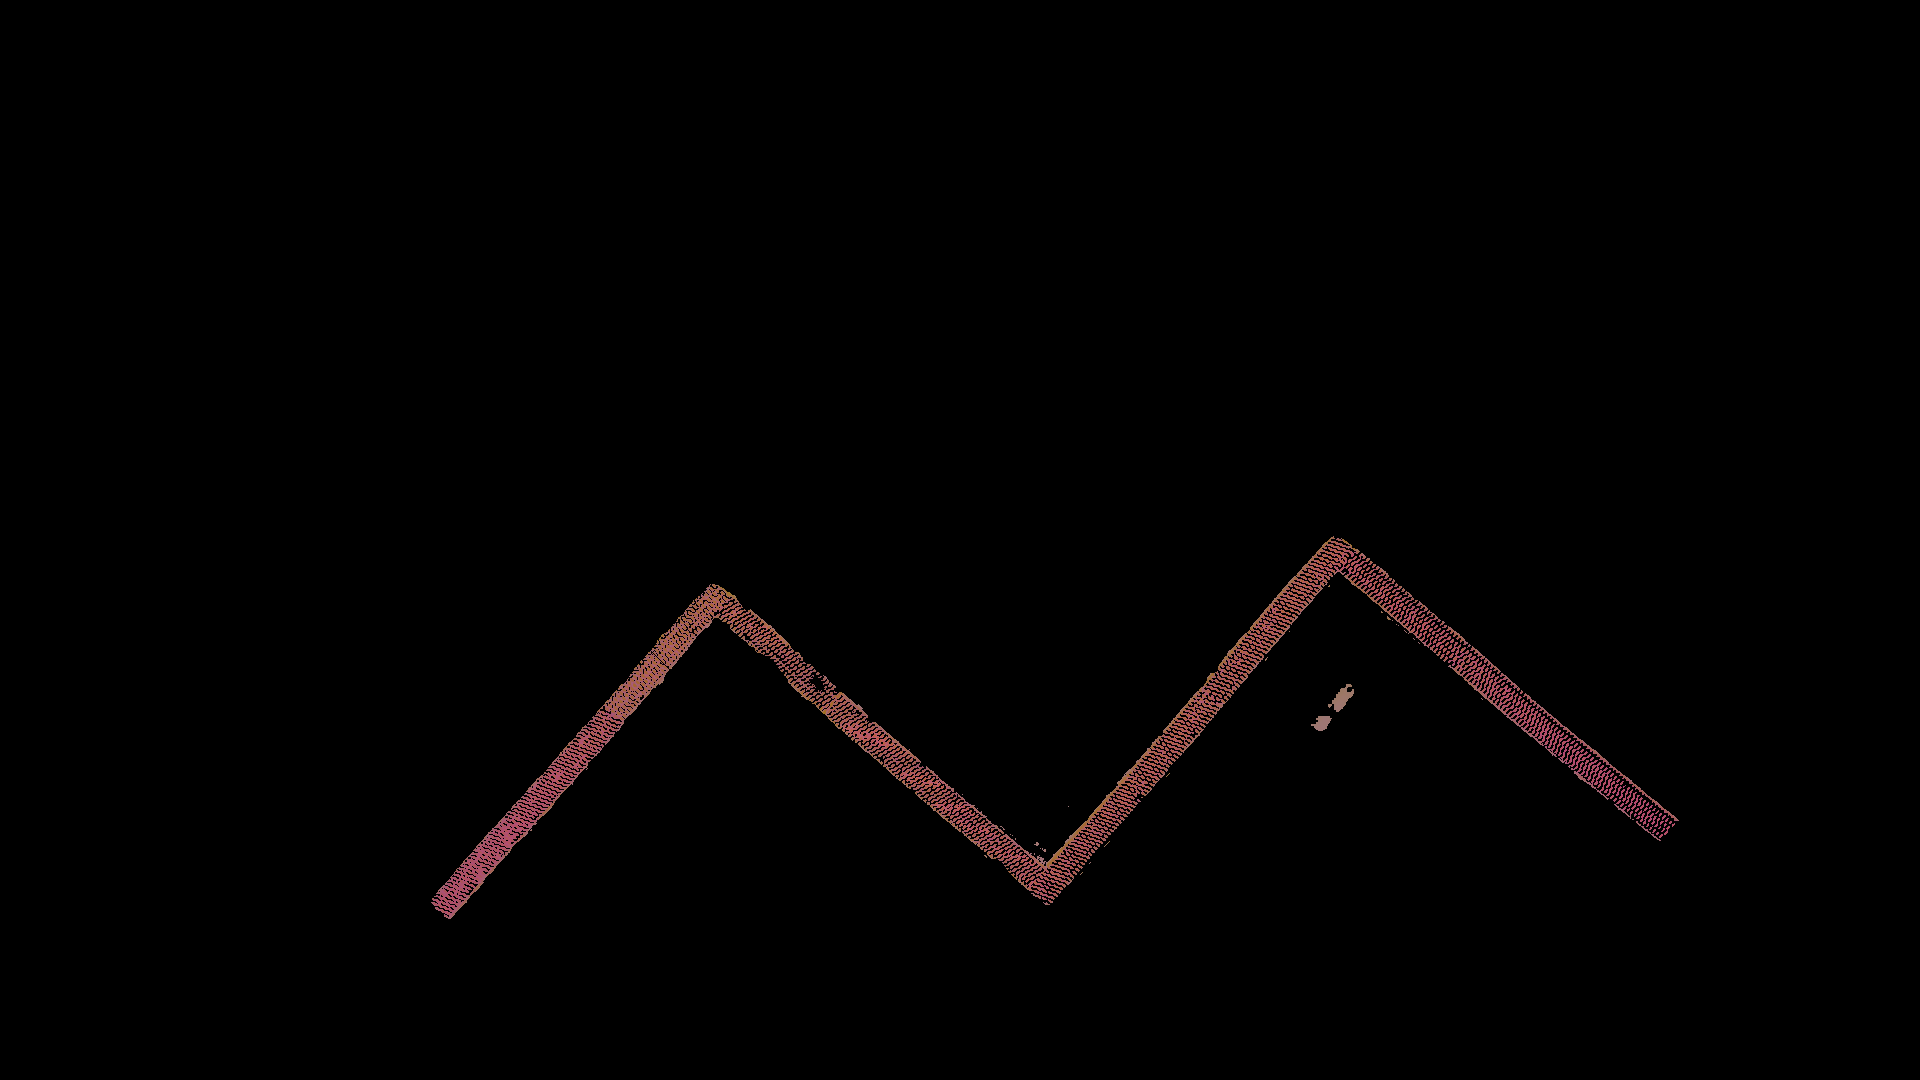

In [ ]:
image = cv2.imread('Image_lines.jpg')
img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
y, u, v = cv2.split(img_yuv)
cv2_imshow(img_yuv)
cv2_imshow(img_yuv[620:650,650:700,:])
print(np.shape(img_yuv))
print(img_yuv[635,675,:])
img_yuv[np.where((y<20) | (y>120) | (u<50) | (u>120) | (v<156) | (y>180) )[0],np.where((y<20) | (y>120) | (u<50) | (u>120) | (v<156) | (y>180)),:] = 0
cv2_imshow(img_yuv)
im = Image.fromarray(img_yuv)
im.save("new_img.jpg")

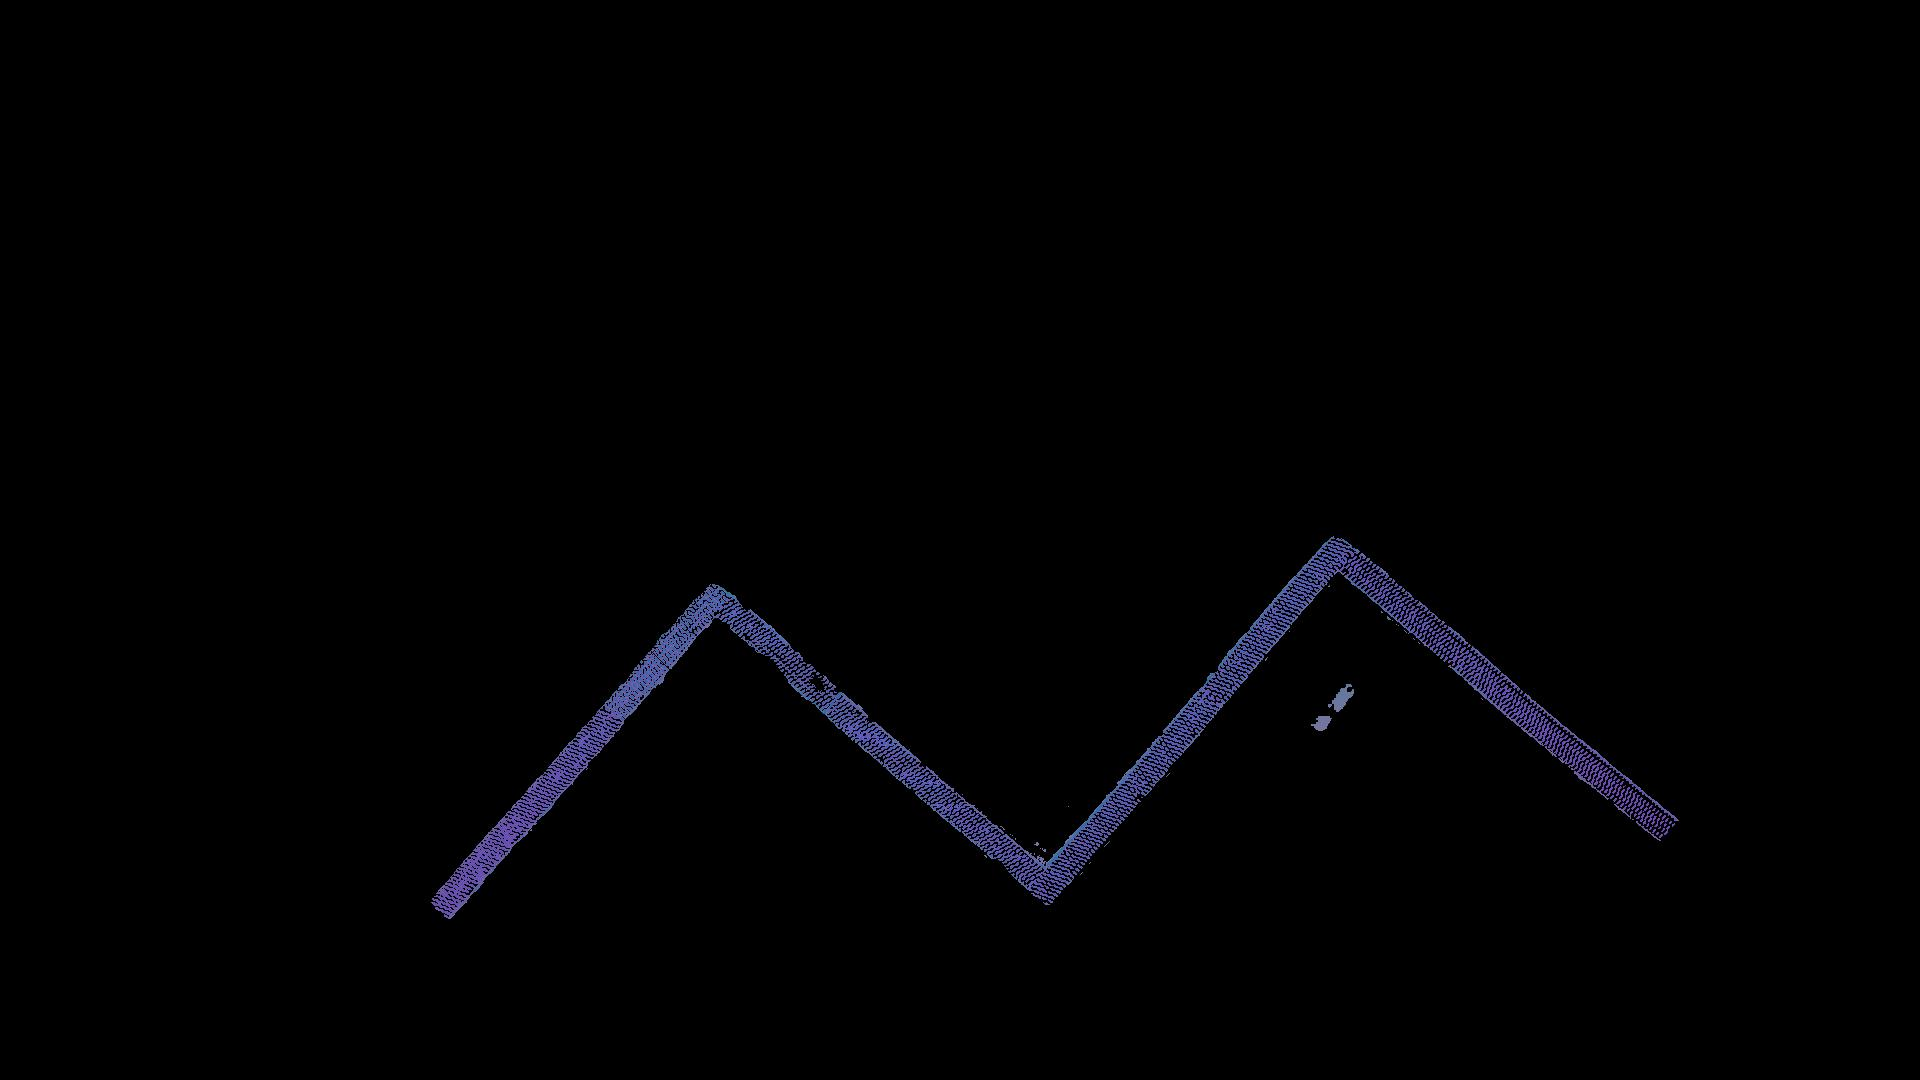

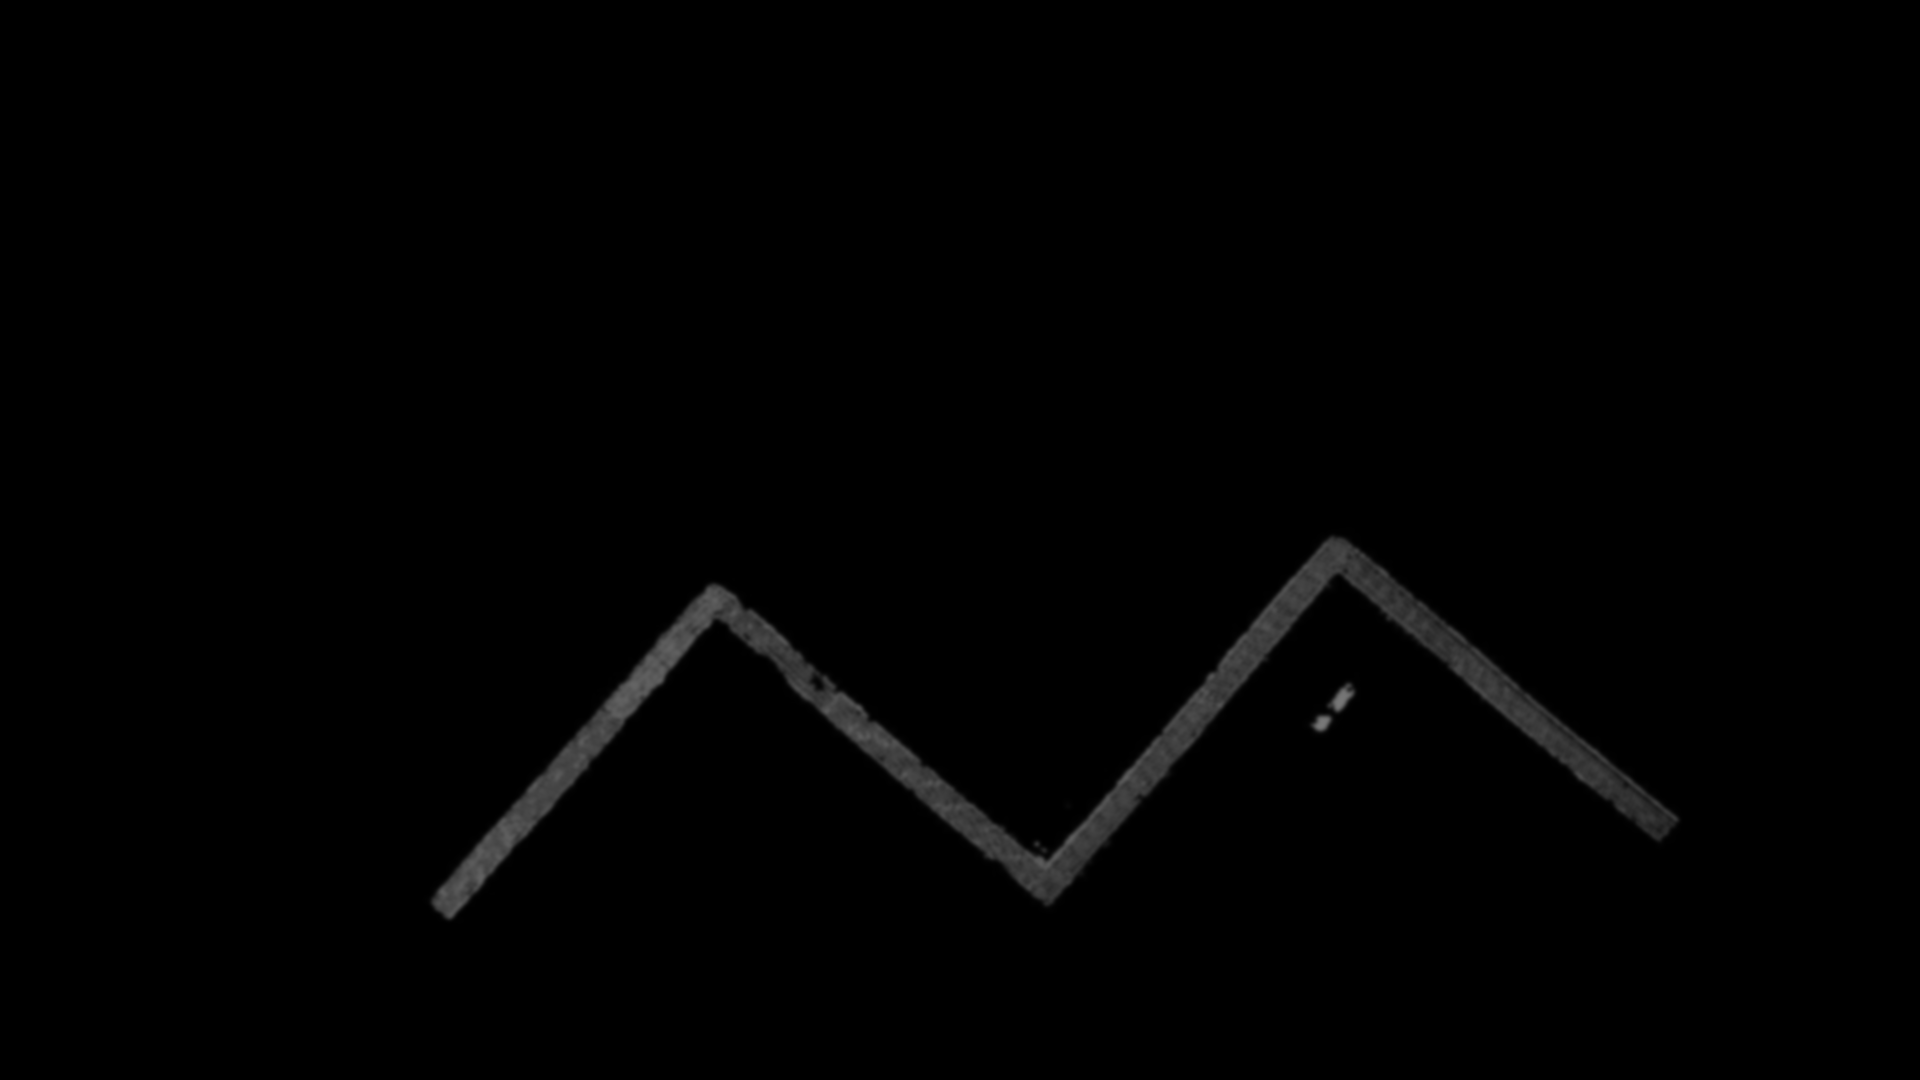

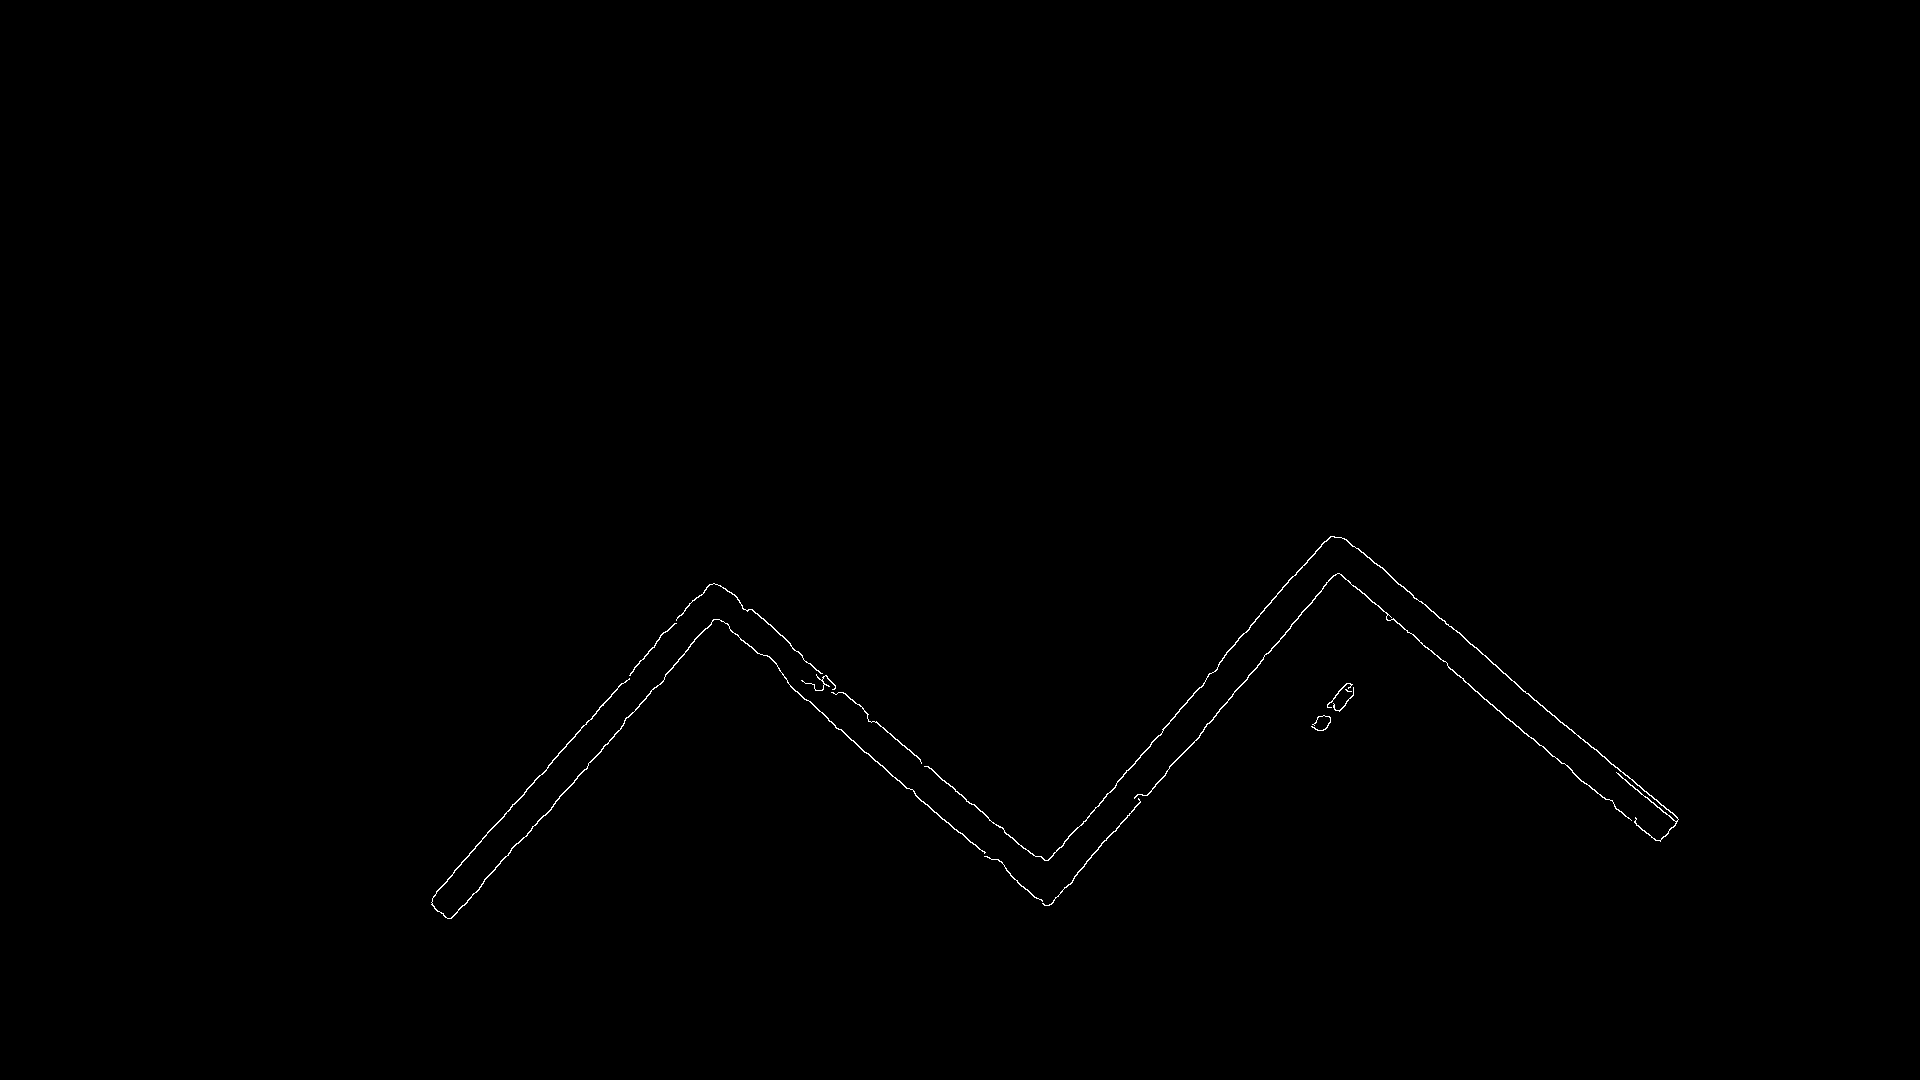

In [ ]:
image_new = cv2.imread('new_img.jpg')
# Taking a matrix of size 5 as the kernel
# kernel = np.ones((2,2), np.uint8)
# image_new = cv2.erode(image_new, kernel, iterations=1)
# load the image, convert it to grayscale, and blur it slightly
gray = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11,11), 0)
# show the original and blurred images
cv2_imshow(image_new)
cv2_imshow(blurred)

# using the Canny edge detector
edges = cv2.Canny(blurred, 50, 150)
# show the output Canny edge maps
cv2_imshow(edges)

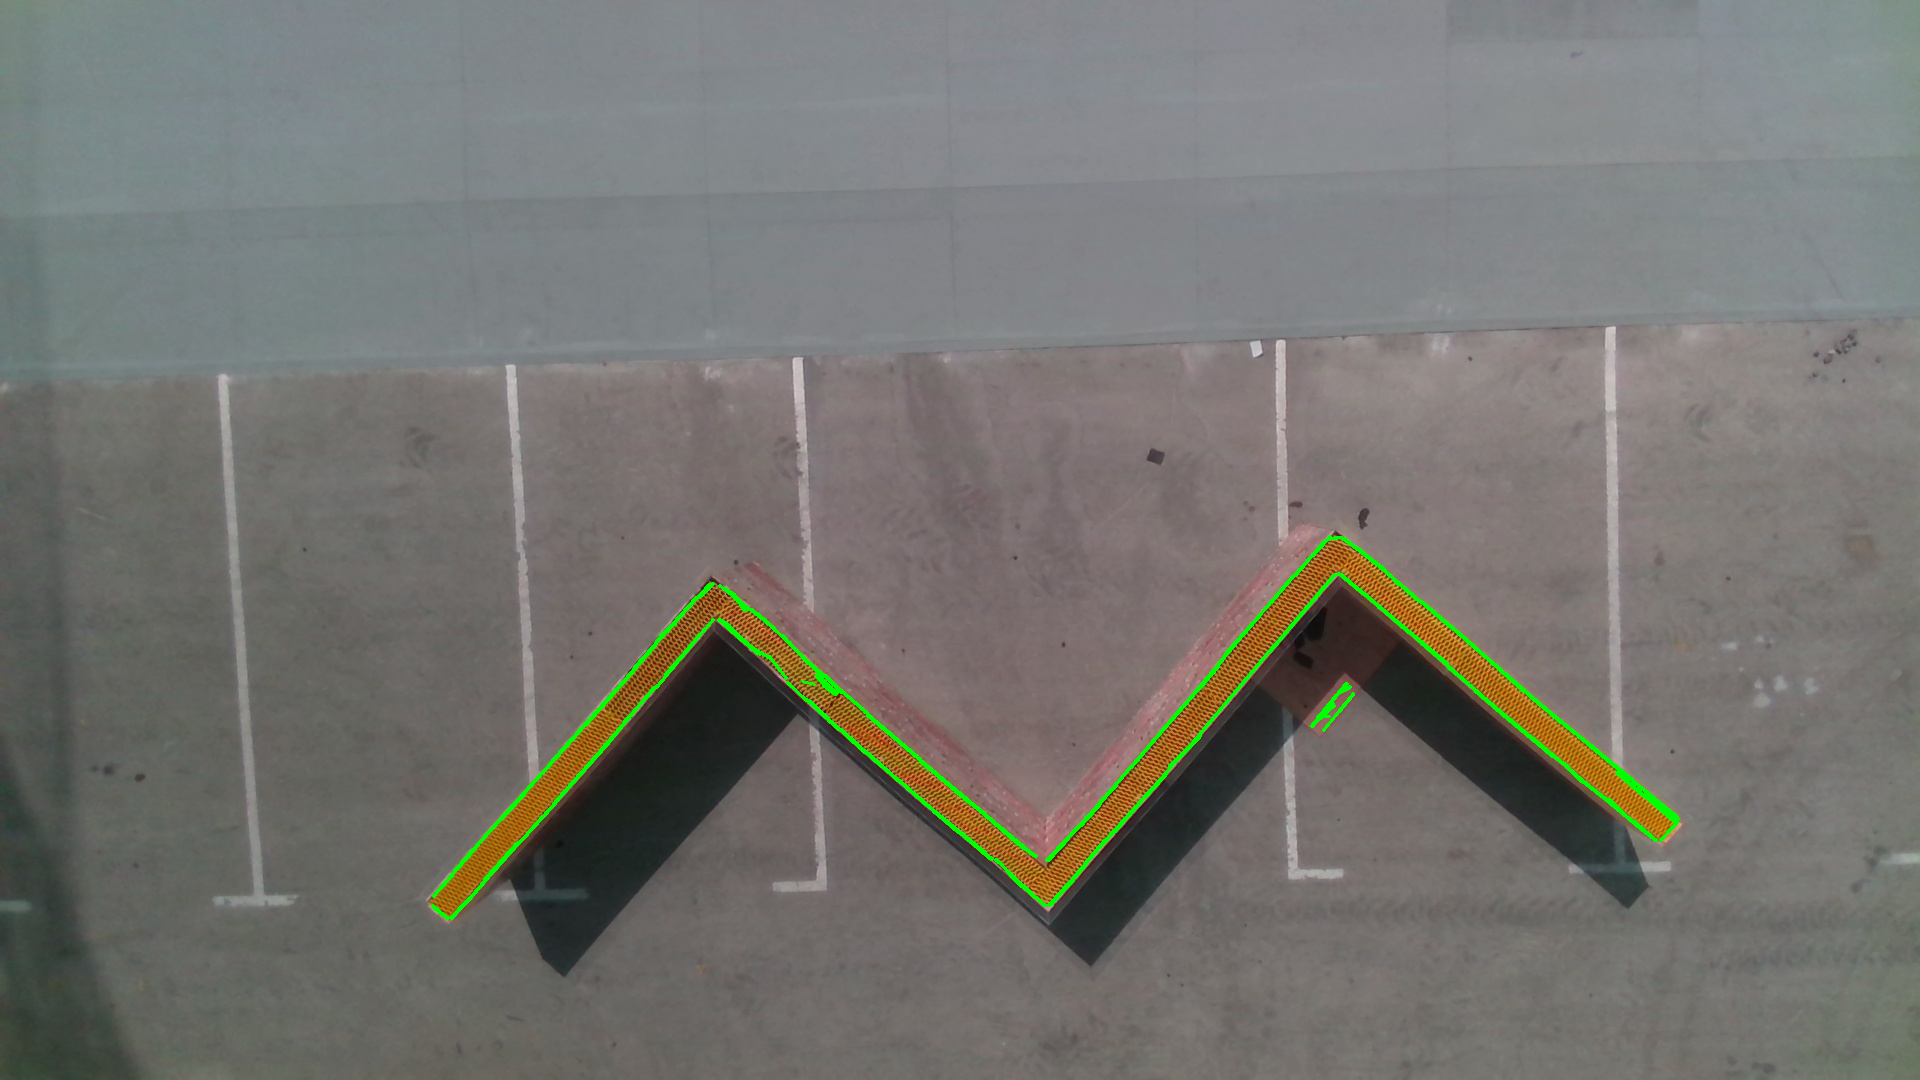

In [ ]:
minLineLength = 30
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)

cv2_imshow(image)

Perspective-n-Point

In [ ]:
def RemoveNoise(mask):
  #define kernel size  
  kernel = np.ones((7,7),np.uint8)
  # Remove unnecessary noise from mask
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
  # Erode and dilate to fill in the gaps in mask
  mask = cv2.erode(mask, None, iterations=2)
  mask = cv2.dilate(mask, None, iterations=2)
  return mask

def FindCentreandRadius(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    center = (0,0)
    radius = 0

    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = int(M["m10"] / M["m00"]) , int(M["m01"] / M["m00"])
        # area = cv2.contourArea(c)
        # radius = math.sqrt(area/math.pi)

    return center,radius

In [ ]:
img1 = cv2.imread('box_2faces.jpg')

GOLD_MIN = np.array([15, 150, 100],np.uint8)
GOLD_MAX = np.array([25, 255, 255],np.uint8)

YELLOW_MIN = np.array([25, 150, 100],np.uint8)
YELLOW_MAX = np.array([35, 255, 255],np.uint8)

GREEN_MIN = np.array([70, 100, 0],np.uint8)
GREEN_MAX = np.array([100, 255, 100],np.uint8)

RED_MIN = np.array([160, 100, 100],np.uint8)
RED_MAX = np.array([179, 255, 255],np.uint8)

hsv_img = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)

mask1_gold = cv2.inRange(hsv_img, GOLD_MIN, GOLD_MAX)
mask1_gold = RemoveNoise(mask1_gold)
#cv2_imshow(mask1_gold)
center_gold,radius_gold = FindCentreandRadius(mask1_gold)
print(f"centre of gold marker is {center_gold} and the radius is {radius_gold}\n")

mask1_yellow = cv2.inRange(hsv_img, YELLOW_MIN, YELLOW_MAX)
mask1_yellow = RemoveNoise(mask1_yellow)
#cv2_imshow(mask1_yellow)
center_yellow,radius_yellow = FindCentreandRadius(mask1_yellow)
print(f"centre of yellow marker is {center_yellow} and the radius is {radius_yellow}\n")

mask1_green = cv2.inRange(hsv_img, GREEN_MIN, GREEN_MAX)
mask1_green = RemoveNoise(mask1_green)
#cv2_imshow(mask1_green)
center_green,radius_green = FindCentreandRadius(mask1_green)
print(f"centre of green marker is {center_green} and the radius is {radius_green}\n")

mask1_red = cv2.inRange(hsv_img, RED_MIN, RED_MAX)
mask1_red = RemoveNoise(mask1_red)
#cv2_imshow(mask1_red)
center_red,radius_red = FindCentreandRadius(mask1_red)
print(f"centre of red marker is {center_red} and the radius is {radius_red}\n")

centre of gold marker is (524, 498) and the radius is 37.000099182128906

centre of yellow marker is (721, 421) and the radius is 47.07450866699219

centre of green marker is (632, 430) and the radius is 49.86608123779297

centre of red marker is (873, 482) and the radius is 38.05926513671875



In [ ]:
points_2D = np.array([
                        center_gold,  # gold
 
                        center_yellow,  # yellow
 
                        center_green,  # green
 
                        center_red,  # red
 
                      ], dtype="double")
 
 
 
points_3D = np.array([
                      (0.0, 17.5, 3.6),   # gold

                      (3.5, 0.0, 10.2),   # yellow

                      (0.0, 3.7, 9.8),   # green

                      (18.3, 0.0, 3.5),   # red

                     ])

camera_matrix = np.array([[699.713,0,641.876],[0,699.713,377.047],[0,0,1]])

	
dist_coeffs = np.zeros((4,1))

success, rotation_vector, translation_vector = cv2.solvePnP(points_3D, points_2D, camera_matrix, dist_coeffs, flags=0)
 
print(f'rotation vector is \n{rotation_vector}\ntranslation vector is \n{translation_vector}') 
#nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)



rotation vector is 
[[ 1.56492181]
 [-0.61149935]
 [ 0.45687006]]
translation vector is 
[[ 2.47814492]
 [12.96762501]
 [38.60474623]]


In [ ]:
img2 = cv2.imread('box_3faces.jpg')
#cv2_imshow(img2)
GOLD_MIN = np.array([15, 100, 100],np.uint8)
GOLD_MAX = np.array([25, 255, 255],np.uint8)

YELLOW_MIN = np.array([25, 150, 100],np.uint8)
YELLOW_MAX = np.array([35, 255, 255],np.uint8)

GREEN_MIN = np.array([70, 80, 0],np.uint8)
GREEN_MAX = np.array([100, 255, 100],np.uint8)

RED_MIN = np.array([175, 100, 100],np.uint8)
RED_MAX = np.array([179, 255, 255],np.uint8)

MAROON_MIN = np.array([165, 160, 20],np.uint8)
MAROON_MAX = np.array([175, 255, 255],np.uint8)

BLUE_MIN = np.array([100, 70, 20],np.uint8)
BLUE_MAX = np.array([120, 255, 255],np.uint8)

hsv_img = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)

mask2_maroon = cv2.inRange(hsv_img, MAROON_MIN, MAROON_MAX)
mask2_maroon = RemoveNoise(mask2_maroon)
#cv2_imshow(mask2_maroon)
center_maroon,radius_maroon = FindCentreandRadius(mask2_maroon)
print(f"centre of maroon marker is {center_maroon} and the radius is {radius_maroon}\n")

mask2_blue = cv2.inRange(hsv_img, BLUE_MIN, BLUE_MAX)
mask2_blue = RemoveNoise(mask2_blue)
#cv2_imshow(mask2_blue)
center_blue,radius_blue = FindCentreandRadius(mask2_blue)
print(f"centre of blue marker is {center_blue} and the radius is {radius_blue}\n")

mask2_gold = cv2.inRange(hsv_img, GOLD_MIN, GOLD_MAX)
mask2_gold = RemoveNoise(mask2_gold)
#cv2_imshow(mask2_gold)
center_gold,radius_gold = FindCentreandRadius(mask2_gold)
print(f"centre of gold marker is {center_gold} and the radius is {radius_gold}\n")

mask2_yellow = cv2.inRange(hsv_img, YELLOW_MIN, YELLOW_MAX)
mask2_yellow = RemoveNoise(mask2_yellow)
#cv2_imshow(mask2_yellow)
center_yellow,radius_yellow = FindCentreandRadius(mask2_yellow)
print(f"centre of yellow marker is {center_yellow} and the radius is {radius_yellow}\n")

mask2_green = cv2.inRange(hsv_img, GREEN_MIN, GREEN_MAX)
mask2_green = RemoveNoise(mask2_green)
#cv2_imshow(mask2_green)
center_green,radius_green = FindCentreandRadius(mask2_green)
print(f"centre of green marker is {center_green} and the radius is {radius_green}\n")

mask2_red = cv2.inRange(hsv_img, RED_MIN, RED_MAX)
mask2_red = RemoveNoise(mask2_red)
#cv2_imshow(mask2_red)
center_red,radius_red = FindCentreandRadius(mask2_red)
print(f"centre of red marker is {center_red} and the radius is {radius_red}\n")

centre of maroon marker is (762, 386) and the radius is 32.388370513916016

centre of blue marker is (551, 397) and the radius is 34.52545166015625

centre of gold marker is (522, 505) and the radius is 30.70026206970215

centre of yellow marker is (681, 512) and the radius is 38.003387451171875

centre of green marker is (610, 516) and the radius is 37.73602294921875

centre of red marker is (807, 501) and the radius is 29.841346740722656



In [ ]:
points_2D = np.array([
                        center_maroon,  # maroon
 
                        center_blue,  # blue
 
                        center_gold,  # gold
 
                        center_yellow,  # yellow
                      
                        center_green, # green
                      
                        center_red, # red
 
                      ], dtype="double")
 
 
 
points_3D = np.array([
                      (17.2, 4.6, 13.3),   # maroon

                      (3.7, 16.1, 13.3),   # blue

                      (0.0, 17.5, 3.6),   # gold

                      (3.5, 0.0, 10.2),   # yellow

                      (0.0, 3.7, 9.8),   # green

                      (18.3, 0.0, 3.5),   # red

                     ])

camera_matrix = np.array([[699.713,0,641.876],[0,699.713,377.047],[0,0,1]])

	
dist_coeffs = np.zeros((4,1))

success, rotation_vector, translation_vector = cv2.solvePnP(points_3D, points_2D, camera_matrix, dist_coeffs, flags=0)
 
print(f'rotation vector is \n{rotation_vector}\ntranslation vector is \n{translation_vector}') 
#nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)



rotation vector is 
[[ 1.90932518]
 [-0.74328614]
 [ 0.38060654]]
translation vector is 
[[ 0.72043301]
 [19.78779003]
 [51.78589237]]
